In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from requests_html import HTMLSession
from collections import defaultdict
from datetime import datetime
import requests
from nltk import corpus
from unidecode import unidecode
import PyPDF2
from sklearn.model_selection import train_test_split
from nltk import corpus
from tqdm.notebook import tqdm
import collections

In [2]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

with HTMLSession() as sess:
    r = sess.get(url)

anuncios = r.html.find("tr")
len(anuncios)

184

In [3]:
#########################Lista de todos los comunicados en la página web de Banxico(Ej 1)
base_anuncios = []
for anun in range(len(anuncios)):
    dt = r.html.find("td[class='bmdateview']")[anun].text
    dt = pd.to_datetime(dt, format='%d/%m/%y')
    title_1 = r.html.find("td[class='bmtextview']")[anun]
    title,*_ = re.findall(".*(?=\nTexto)",title_1.text)
    link,*_ = r.html.find("td[class='bmtextview']")[anun].absolute_links
    base_anuncios.append([dt, title,link])

##########################Filtro de comunicados en pandas df desde la fecha que queremos (Ej 1)
df = pd.DataFrame(base_anuncios,columns=["date","text","url"]).set_index("date")
df = df.loc[df.index > pd.Timestamp(2008,2,15)]

##########################Guardar tabla en pkl (Ej 1)
df.to_pickle("tabla_anuncios.pkl")

In [4]:
#Definición de clases (Ej 2)
df["category"] = df.text.str.extract("(disminuye|incrementa|sin cambio|aumenta|reduce)")

In [5]:
####################################Conteo de categorías (Ej 3)
df.groupby("category").size()

category
disminuye     16
incrementa    18
sin cambio    71
dtype: int64

C:\Users\O61291\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


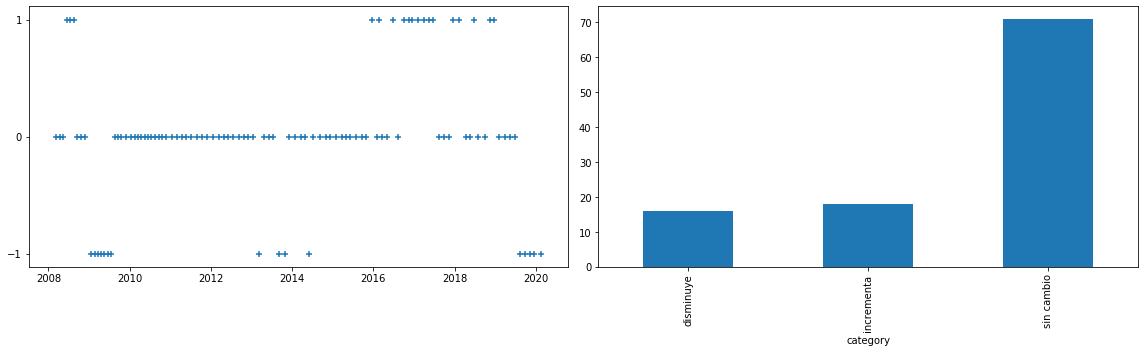

In [6]:
####################################Gráficas (Ej 4)
def cat_num(cat):
    switcher = {
        "disminuye": -1,
        "incrementa": 1,
       "sin cambio": 0,
    }
    return switcher.get(cat)

df["cat_num"] = [cat_num(x) for x in df.category]


fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16,5))
axs[0].scatter(x = df.index, y = df.cat_num,
               marker = "+")
axs[0].set_yticks([-1,0,1])
axs[1] = df["cat_num"].groupby(df.category).count().plot(kind="bar")
        
plt.show()

In [7]:
####################################Agrupar anuncios por categoria y año (Ej 5)
agrupado = (df.groupby([df.index.strftime('%Y'),'category'])['category']
    .count())
    
agrupado

      category  
2008  incrementa     3
      sin cambio     6
2009  disminuye      7
      sin cambio     4
2010  sin cambio    11
2011  sin cambio     8
2012  sin cambio     8
2013  disminuye      3
      sin cambio     5
2014  disminuye      1
      sin cambio     7
2015  incrementa     1
      sin cambio     7
2016  incrementa     5
      sin cambio     4
2017  incrementa     5
      sin cambio     3
2018  incrementa     4
      sin cambio     4
2019  disminuye      4
      sin cambio     4
2020  disminuye      1
Name: category, dtype: int64

In [8]:
#################################### Aux (Ej 6)
sin_cambio = pd.DataFrame(agrupado.xs('sin cambio', level=1)).rename(columns={"category": "sin_cambio"})
disminuye = pd.DataFrame(agrupado.xs('disminuye', level=1)).rename(columns={"category": "disminuye"})
incrementa = pd.DataFrame(agrupado.xs('incrementa', level=1)).rename(columns={"category": "incrementa"})


agrupado_2 = sin_cambio.join(disminuye).join(incrementa).fillna(0)

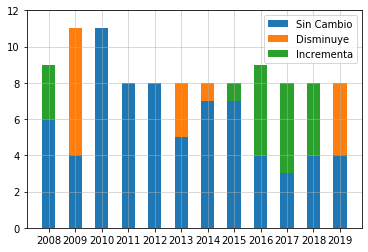

In [9]:
#################################### Gráfica (Ej 6)
N = len(agrupado_2)
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, agrupado_2['sin_cambio'], width)
p2 = plt.bar(ind, agrupado_2['disminuye'], width,
             bottom=agrupado_2['sin_cambio'])
p3 = plt.bar(ind, agrupado_2['incrementa'], width,
             bottom=agrupado_2['sin_cambio'])

plt.xticks(ind, agrupado_2.index)
plt.yticks(np.arange(0, 13, 2))
plt.legend((p1[0], p2[0], p3[0]), ('Sin Cambio', 'Disminuye', 'Incrementa'))
plt.grid(alpha=0.6)

plt.show()

In [10]:
##########################Extracción de pdfs en local (Ej 7)
for i in range(len(df)):
    url = df['url'][i]
    r = requests.get(url)
    
    paper = r.content

    if not os.path.exists("descargas_banxico"):  
        os.mkdir("descargas_pdfs")
    
    full_path = os.path.join("descargas_banxico", f"paper{i}.pdf")
    
    with open(full_path,"wb") as f: # wb write binary
        f.write(paper)

In [11]:
d = defaultdict(list)

for i in range(len(df)):
    
    full_path = os.path.join("descargas_banxico", f"paper{i}.pdf")
    
    pdf_file = open(full_path, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = collections.Counter(range(number_of_pages))

    text_paper_i = ''
    for j in c:
       page = read_pdf.getPage(j)
       page_content = page.extractText()
       text_paper_i = text_paper_i + page_content
            
    d[df['category'][i]].append(text_paper_i)

In [12]:
k1, k2, k3 = 'sin cambio', 'incrementa', 'disminuye'

In [13]:
#############################Función para limpiar texto
def limpia_texto(texto):
    cln = texto.lower()
    cln = re.sub("[^\w ]", "", cln)
    return cln

In [14]:
D1 = [limpia_texto(doc) for doc in d[k1]]
D2 = [limpia_texto(doc) for doc in d[k2]]
D3 = [limpia_texto(doc) for doc in d[k3]]

D1, D1_test = train_test_split(D1,test_size = 0.2)
D2, D2_test = train_test_split(D2,test_size = 0.2)
D3, D3_test = train_test_split(D3,test_size = 0.2)


In [15]:
N1 = len(D1)
N2 = len(D2)
N3 = len(D3)
N = N1 + N2 + N3
N

82

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\O61291\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [32]:
stopwords = nltk.corpus.stopwords.words("spanish")
aditional_stopwords = ['mantener','disminuir','incrementar', 'mantengan','disminuyan','incrementen','además','general','vez']
stopwords = stopwords + aditional_stopwords
stopwords = [unidecode(word) for word in stopwords]
len(stopwords)

322

In [33]:
V1 = [palabra for dialogo in D1 for palabra in dialogo.split() if palabra not in stopwords]
V2 = [palabra for dialogo in D2 for palabra in dialogo.split() if palabra not in stopwords]
V3 = [palabra for dialogo in D3 for palabra in dialogo.split() if palabra not in stopwords]

V1_c = pd.Series(V1, name='k1').value_counts()
V2_c = pd.Series(V2, name = 'k2').value_counts()
V3_c = pd.Series(V3, name = 'k3').value_counts()


V = set(V1) | set(V2) | set(V3)
vocab = pd.DataFrame(index=V)
vocab.shape

# likelihood
L = (vocab.join(V1_c, how = "left")
    .join(V2_c, how = "left")
    .join(V3_c, how = "left"))

L = L.fillna(0) + 1 #numerador 
L = L / L.sum(axis=0) # L.sum(axis=0)  suma el total por clase 

L.sort_values("k1",ascending = False)
L.sample(10)

,k1,k2,k3
abundante,0.000125,0.00008,0.000121
presentaría,0.000063,0.00008,0.000121
expandiéndose,0.000313,0.00048,0.000121
reacción,0.000063,0.00016,0.000121
299,0.000031,0.00008,0.000242
pudieran,0.001126,0.00024,0.001572
alguna,0.000094,0.00008,0.000121
comenzar,0.000063,0.00008,0.000121
ambas,0.000125,0.00016,0.000121
máximos,0.000063,0.00016,0.000121


In [34]:
log_L = np.log(L)

log_prior_k1 = np.log(N1/N)
log_prior_k2 = np.log(N2/N)
log_prior_k3 = np.log(N3/N)

log_priors = np.array([log_prior_k1,log_prior_k2,log_prior_k3])

In [35]:
D_test = D1_test + D2_test + D3_test
print(len(D_test))
y_test = ["k1"]*len(D1_test) + ["k2"]*len(D2_test) + ["k3"]*len(D3_test)

23


In [36]:
yhat_test = [] 
for d_test in D_test:
    f = set([palabra for palabra in d_test.split() if palabra in V])
    res = log_L.loc[f].sum(axis=0) + log_priors
    yhat_test.append(res.idxmax())

print(y_test)
print(yhat_test)

['k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k2', 'k2', 'k2', 'k2', 'k3', 'k3', 'k3', 'k3']
['k1', 'k2', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k2', 'k2', 'k2', 'k1', 'k3', 'k1', 'k3']


In [37]:
from  sklearn.metrics import confusion_matrix
confusion_matrix(y_test,yhat_test)

array([[14,  1,  0],
       [ 1,  3,  0],
       [ 2,  0,  2]], dtype=int64)

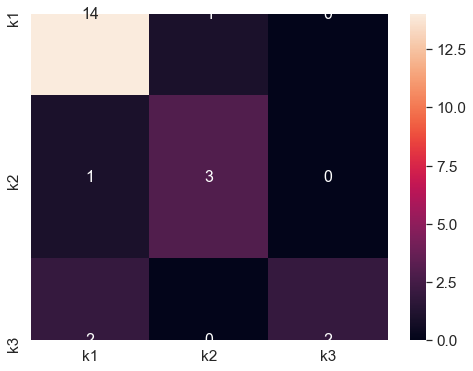

In [30]:
import seaborn as sn
array = confusion_matrix(y_test,yhat_test)
df_cm = pd.DataFrame(array, index = ['k1','k2','k3'],
                  columns = ['k1','k2','k3'])
plt.figure(figsize = (8,6))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})